In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set times new roman as default
# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size']  = 10

In [3]:
### Read data
datacase = 'B'
path_to_data = '/Users/matteosavarese/Desktop/Dottorato/BSC/' + 'Case_' + datacase + '/data_scatter/data.csv'
data = pd.read_csv(path_to_data)
print(data.columns)

Index(['ELEMC', 'ELEMH', 'ELEMO', 'Grad_CH4_0', 'Grad_CH4_1', 'Grad_CH4_2',
       'Grad_CO2_0', 'Grad_CO2_1', 'Grad_CO2_2', 'Grad_CO_0', 'Grad_CO_1',
       'Grad_CO_2', 'Grad_H2O_0', 'Grad_H2O_1', 'Grad_H2O_2', 'Grad_H2_0',
       'Grad_H2_1', 'Grad_H2_2', 'Grad_N2_0', 'Grad_N2_1', 'Grad_N2_2',
       'Grad_O2_0', 'Grad_O2_1', 'Grad_O2_2', 'Grad_OH_0', 'Grad_OH_1',
       'Grad_OH_2', 'HRR', 'Points_0', 'Points_1', 'Points_2', 'TEMPE',
       'TI_CH4', 'U_0', 'U_1', 'Y_CH4', 'Y_CO', 'Y_CO2', 'Y_H2', 'Y_H2O',
       'Y_N2', 'Y_O2', 'Y_OH', 'omega_CH4', 'omega_CO', 'omega_CO2',
       'omega_H2', 'omega_H2O', 'omega_O2'],
      dtype='object')


Text(0, 0.5, 'y (m)')

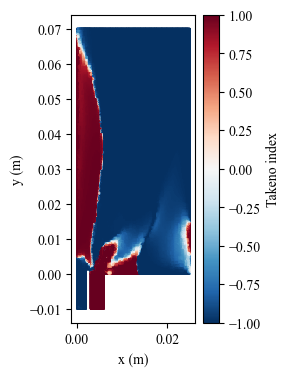

In [6]:
# Scatter plot takeno index
fig, ax = plt.subplots(figsize=(2,4))
sc = ax.scatter(data['Points_0'], data['Points_1'], c=data['TI_CH4'], s=0.1, cmap='RdBu_r')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Takeno index')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')


/var/folders/mw/ms39fpqd5d7fy8th9qs6p5100000gn/T/ipykernel_41297/3518854947.py:8: DeprecationWarning: XML_Node::build: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  gas1 = ct.Solution('gri30.xml')


Oxidizer mixture fraction =  0.044625496866507366


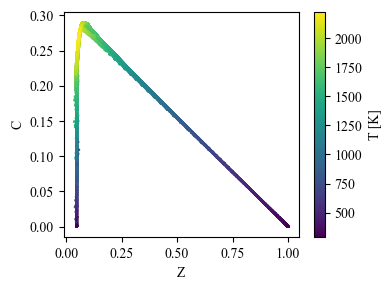

In [9]:
# Extract mass fractions, temperature and reaction rates
mass_fractions = data.filter(like='Y')
Temp           = data['TEMPE']
reaction_rates = data.filter(like='omega')
gradients      = data.filter(like='Grad')

# Use cantera and elemental fractions to calculate mixture fraction
import cantera as ct
gas1 = ct.Solution('gri30.xml')
gas2 = ct.Solution('gri30.xml')

fuel = 'CH4:1'
air  = 'N2:0.79, O2:0.21'

# Fuel composition
if datacase == 'A' or datacase == 'B':
    fuel_comp = fuel
elif datacase == 'C' or datacase == 'D':
    gas1.set_equivalence_ratio(2, fuel=fuel, oxidizer=air)
    fuel_comp = 'CH4:' + str(gas1.X[gas1.species_index('CH4')]) + ', O2:' + str(gas1.X[gas1.species_index('O2')]) + ', N2:' + str(gas1.X[gas1.species_index('N2')])

# Oxidizer composition
if datacase == 'A' or datacase == 'C':
    gas2.set_equivalence_ratio(0.3, fuel=fuel, oxidizer=air)
    oxi_comp = 'CH4:' + str(gas2.X[gas2.species_index('CH4')]) + ', O2:' + str(gas2.X[gas2.species_index('O2')]) + ', N2:' + str(gas2.X[gas2.species_index('N2')])
elif datacase == 'B' or datacase == 'D':
    gas2.set_equivalence_ratio(0.8, fuel=fuel, oxidizer=air)
    oxi_comp = 'CH4:' + str(gas2.X[gas2.species_index('CH4')]) + ', O2:' + str(gas2.X[gas2.species_index('O2')]) + ', N2:' + str(gas2.X[gas2.species_index('N2')])


# Get the mixture fraction of the oxidizer
f_fuel = gas1.mixture_fraction(fuel=fuel, oxidizer=air, element="Bilger")
f_oxi  = gas2.mixture_fraction(fuel=fuel, oxidizer=air, element="Bilger")

print('Oxidizer mixture fraction = ', f_oxi)

# # Calculate beta fuel and beta oxidizer
fuel_sol = ct.Solution('gri30.xml')
oxi_sol  = ct.Solution('gri30.xml')

fuel_sol.TPX = 300.0, 101325.0, fuel
oxi_sol.TPX  = 300.0, 101325.0, air

# Calculate beta fuel (to be checked)
# bf = 2 * gas1.elemental_mass_fraction('C')/12 + 0.5 * gas1.elemental_mass_fraction('H')
# bo = 2 * gas2.elemental_mass_fraction('C')/12 + 0.5 * gas2.elemental_mass_fraction('H') - gas2.elemental_mass_fraction('O')/16
bf = 2*(12/16)/12 + 0.5*(4/16)
bo = -oxi_sol.elemental_mass_fraction('O')/16

# Calculate mixture fraction
Z = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    beta = 2*data['ELEMC'][i]/12 + 0.5*data['ELEMH'][i] - data['ELEMO'][i]/16
    Z[i] = (beta - bo)/(bf - bo)


# -------------- Progress variable definition ---------------- #
# C1: Pierce & Moin : C = Yco2 + Yh2o
# C2: Ihme & Pitsch : C = Yco2 + Yh2o + Yco + Yh2
# C3: Fiorina et al.: C = Yco2 + Yco

c_type = 'C2'
if c_type == 'C1':
    PV = data['Y_CO2'] + data['Y_H2O']
elif c_type == 'C2':
    PV = data['Y_CO2'] + data['Y_H2O'] + data['Y_CO'] + data['Y_H2']
elif c_type == 'C3':
    PV = data['Y_CO2'] + data['Y_CO']

# ----------------------- Scatter plot ------------------------ #
fig, ax = plt.subplots(figsize=(4,3))
sc = ax.scatter(Z, PV, c=data['TEMPE'], s=1)
ax.set_xlabel('Z'); ax.set_ylabel('C')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('T [K]')
fig.tight_layout()


Text(0, 0.5, 'PC1')

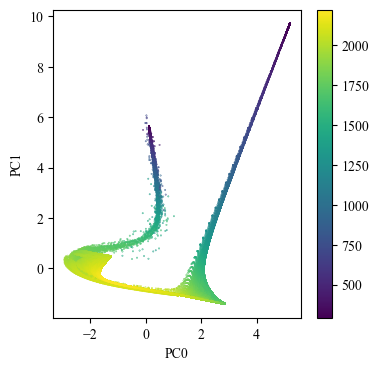

In [11]:
# PCA 
# Pre-process the data (other scalings not available in sklearn must be tested)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_Y = StandardScaler()
scaler_R = StandardScaler()

# Fit and transform (only on mass fractions)
Y_scaled = scaler_Y.fit_transform(mass_fractions)
R_scaled = scaler_R.fit_transform(reaction_rates)

# Apply PCA
from sklearn.decomposition import PCA, SparsePCA

# Project thermo-chemical space
pcay = PCA(n_components=0.999)
U_scores = pcay.fit_transform(Y_scaled)

# Scatter plot
fig, ax = plt.subplots(figsize=(4,4))
sc = ax.scatter(U_scores[:,0], U_scores[:,1], c=data['TEMPE'], s=0.1)
cb = fig.colorbar(sc, ax=ax)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')


In [12]:
# Check correlation between scores and variables, plus C and Z
from scipy.stats import pearsonr
# Calculate correlation coefficients
correlation_coefficients = []
num_features = Y_scaled.shape[1]
pc = 0
for i in range(num_features):
    correlation, _ = pearsonr(Y_scaled[:, i], U_scores[:, pc])  # Using PC1 as an example
    correlation_coefficients.append(correlation)

correlation, _ = pearsonr(Z, U_scores[:, pc])  # Mixture fraction
correlation_coefficients.append(correlation)

correlation, _ = pearsonr(PV, U_scores[:, pc])  # Mixture fraction
correlation_coefficients.append(correlation)

feature_names = ['CH4', 'CO', 'CO2', 'H2', 'H2O', 'N2', 'O2', 'OH', 'Z', 'C']
# # Print the results
print(f"Correlation coefficients with PC{pc+1}:")
for i, coefficient in enumerate(correlation_coefficients):
    print(f"Variable {feature_names[i]}: {coefficient:.4f}")


Correlation coefficients with PC1:
Variable CH4: 0.4423
Variable CO: 0.8360
Variable CO2: -0.8241
Variable H2: 0.8486
Variable H2O: 0.0234
Variable N2: -0.5499
Variable O2: -0.3617
Variable OH: -0.8875
Variable Z: 0.5481
Variable C: 0.0517


In [14]:
# Varimax rotation from Factor Analysis #
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=U_scores.shape[1], rotation='varimax')
fa.fit(Y_scaled)
# Rotated components
rot_comp = fa.components_.T
# Rotated scores
V_scores = fa.transform(Y_scaled)

Correlation coefficients with PC1:
Variable CH4: 0.9972
Variable CO: -0.0759
Variable CO2: -0.4950
Variable H2: -0.0469
Variable H2O: -0.5915
Variable N2: -0.9901
Variable O2: -0.1375
Variable OH: -0.2066
Variable Z: 0.9905
Variable C: -0.5833


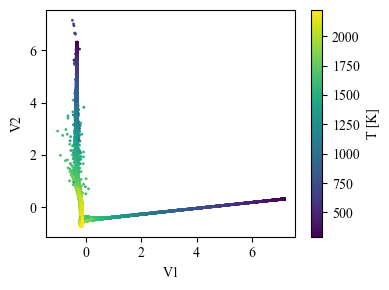

In [15]:
# Calculate correlation coefficients
correlation_coefficients = []
num_features = Y_scaled.shape[1]
pc = 0
for i in range(num_features):
    correlation, _ = pearsonr(Y_scaled[:, i], V_scores[:, pc])  # Using PC1 as an example
    correlation_coefficients.append(correlation)

correlation, _ = pearsonr(Z, V_scores[:, pc])  # Mixture fraction
correlation_coefficients.append(correlation)

correlation, _ = pearsonr(PV, V_scores[:, pc])  # Mixture fraction
correlation_coefficients.append(correlation)

feature_names = ['CH4', 'CO', 'CO2', 'H2', 'H2O', 'N2', 'O2', 'OH', 'Z', 'C']
# # Print the results
print(f"Correlation coefficients with PC{pc+1}:")
for i, coefficient in enumerate(correlation_coefficients):
    print(f"Variable {feature_names[i]}: {coefficient:.4f}")

fig, ax = plt.subplots(figsize=(4,3))
sc = ax.scatter(V_scores[:,0], V_scores[:,1], c=data['TEMPE'], s=1)
ax.set_xlabel('V1'); ax.set_ylabel('V2')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('T [K]')
fig.tight_layout()

In [20]:
### ------------------- Perform VQPCA ------------------ ###
import OpenMORe.clustering as clustering
from OpenMORe.utilities import *

# Function to decide which data you want to use
def SelectData(select="species", transform=False):
    global gradients
    if select == "species":
        X = np.array(mass_fractions)
    
    elif select == "gradients" and transform == False:
        X = np.hstack((np.array(mass_fractions), np.array(gradients)))
    
    elif select == "gradients" and transform == True:
        gradients = np.array(gradients)
        gradients_t = np.zeros_like(gradients)
        for i in range(gradients.shape[1]):
            gradients_t[:,i] = np.sign(gradients[:,i]) * np.log10(1 + np.abs(gradients[:,i]))
        X = np.hstack((np.array(mass_fractions), gradients_t))

    return X

X = SelectData(select="gradients", transform=True)

# Dictionary with the instruction for the LPCA algorithm:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "pareto",

    #set the initialization method (random, observations, kmeans, pkcia, uniform)
    "initialization_method"     : "uniform",

    #set the number of clusters and PCs in each cluster
    "number_of_clusters"        : 7,
    "number_of_eigenvectors"    : 2,

    #enable additional options:
    "correction_factor"         : "off",    # --> enable eventual corrective coefficients for the LPCA algorithm:
                                            #     'off', 'c_range', 'uncorrelation', 'local_variance', 'phc_multi', 'local_skewness' are available

    "classify"                  : False,    # --> call the method to classify a new matrix Y on the basis of the lpca clustering
    "write_on_txt"              : False,     # --> write the idx vector containing the label for each observation
    "evaluate_clustering"       : False,     # --> enable the calculation of indeces to evaluate the goodness of the clustering
    
    #improve the clustering solution via kNN
    "kNN_post"                  : False,     # activate the kNN algorithm once the convergence is achieved
    "neighbors_number"          : 40,       # set the number of neighbors that has to be taken into account
}

model = clustering.lpca(X, settings)
index, eigenvectors = model.fit()


	It will be automatically set equal to: 'nPCs'.
	You can ignore this warning if the stopping method has been assigned later via setter.
	Otherwise, please check the conditions which must be satisfied by the input in the detailed documentation.
Preprocessing training matrix..
Fitting Local PCA model...
- Iteration number: 1
	Reconstruction error: 0.9146444831523688
	Reconstruction error variance: 0.09332097707892906
- Iteration number: 2
	Reconstruction error: 0.2729667613092754
	Reconstruction error variance: 2.3507540579860673
- Iteration number: 3
	Reconstruction error: 0.2583234175646943
	Reconstruction error variance: 0.0566860870866026
- Iteration number: 4
	Reconstruction error: 0.257599133073142
	Reconstruction error variance: 0.002811672861284984
- Iteration number: 5
	Reconstruction error: 0.257524970962468
	Reconstruction error variance: 0.00028798027001716056
- Iteration number: 6
	Reconstruction error: 0.25748565898864323
	Reconstruction error variance: 0.000152676362556149

In [ ]:
# Scatter plot of VQPCA results 
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create two different colormaps
cmap1 = plt.get_cmap('viridis')
cmap2 = plt.get_cmap('RdBu_r')

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 4))

# Scatter plot of clustering
sc1 = ax1.scatter(-data['Points_0'], data['Points_1'], c=index, s=0.1)
ax1.set_title('VQPCA')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('Y')
# Scatter plot of Takeno
sc2 = ax2.scatter(data['Points_0'], data['Points_1'], c=data['TI_CH4'], s=0.1, cmap="RdBu_r")
ax2.set_title('TI')
ax2.set_xlabel('x (m)')
# Remove y-axis line and tick labels for both plots
for ax in [ax1, ax2]:
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
# Reduce space between subplots boxes
plt.subplots_adjust(wspace=0.01, hspace=0.01)

